## Examples

Below is a simple staggered grid example that we will be working with.

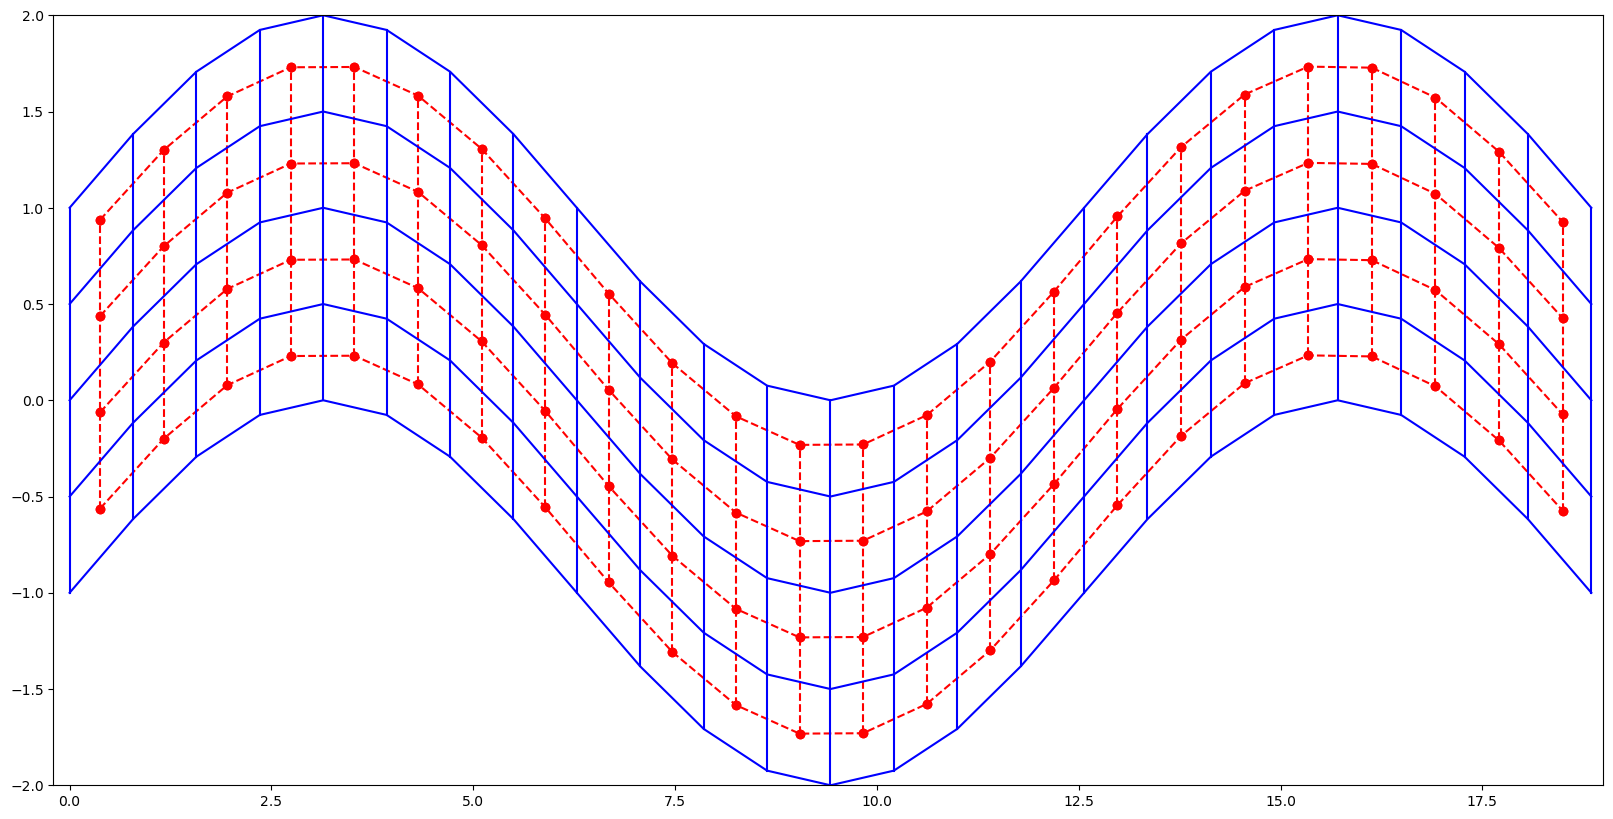

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from gnome.environment import GridCurrent
import pprint as pp

fn = 'staggered_sine_channel.nc'
gc = GridCurrent.from_netCDF(filename=fn)
gc2 = GridCurrent.from_netCDF(filename=fn, varnames=['u_psi', 'v_psi'])
g = gc.grid

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, xlim=[-0.2, 19], ylim=[-2, 2])
g.draw_to_plot(ax, features=['node', 'center'], style={'node':{'color':'red'}})


### Customizing environment objects

Environment objects are complicated entities that combine many functions in a configurable framework. There are many different levels of complexity available to the user, and often several ways to accomplish the same goal. This section is intended to detail these options so the user can maximize their effectiveness with the system.

In [2]:
gc = GridCurrent.from_netCDF('staggered_sine_channel.nc')

This is the simplest way to create an environment object, but also requires the most standardized data. The grid, variables, time, and depth must all be able to be created using their respective 'from_netCDF' functions using the default grid variable names, default variable names, etc. Generally, for environment objects the data defaults are located on the object itself:

In [3]:
from gnome.environment import GridTemperature
print GridTemperature.default_names
print GridCurrent.default_names
print gc.varnames
print gc.u.varname
print gc.v.varname
print gc.u is gc.variables[0]

['water_t', 'temp']
{'u': ['u', 'U', 'water_u', 'curr_ucmp'], 'w': ['w', 'W'], 'v': ['v', 'V', 'water_v', 'curr_vcmp']}
['u', 'v', 'constant w']
u
v
True


As we can see, the variables 'u' and 'v' were located and used to construct the object. 'w' was not found, however, and was replaced with a constant 0 instead.

There are three current velocities in this file, all on different grids. there is the ['u', 'v'] pair, which are on separate staggered grids, the ['u_psi', 'v_psi'] pair on the nodes grid, and ['u_rho', 'v_rho'] pair on the center grid. In order to specify one of the other pairs, we do the following:

In [4]:
gc = GridCurrent.from_netCDF(filename=fn, varnames=['u_psi', 'v_psi'])
print gc.varnames

['u_psi', 'v_psi', 'constant w']


Using the 'varnames' keyword, we can specify the variables to be searched for. For all other components of this GridCurrent, it will still use the default construction. This is a general trend throughout the whole system, where there is some reasonable default behavior, and optional complexity accessed by keyword arguments.

One very important keyword argument is the 'grid_topology' keyword. The grid topology describes a relationship between the variables in the netCDF file and parts of the grid. Unless specified, this grid topology is generated based on default names and what is located in the file, or is extracted from an appropriate topology variable within the file itself. Topology variables that follow the *ugrid* or *sgrid* standards are supported. 

Our example file does not have a topology specified, but the names are detected by the defaults, and so a fully realized staggered grid can be created from it. However, we can also specify our own grid topology as a dict:

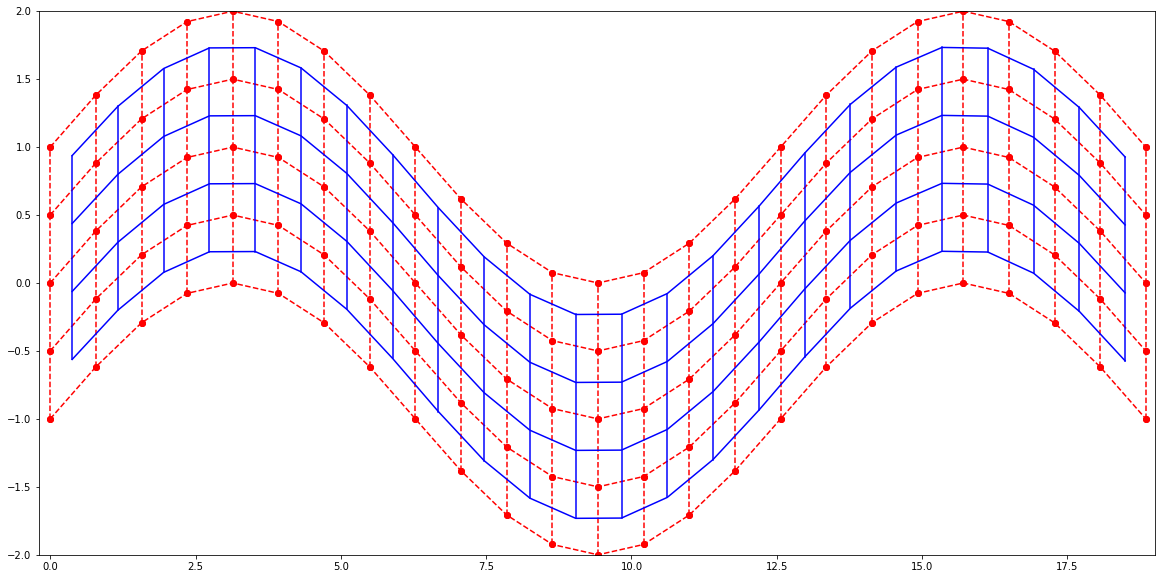

In [5]:
grid_topo = {'node_lon':'lon_rho',
             'node_lat':'lat_rho',
             'center_lon':'lon_psi',
             'center_lat':'lat_psi'}
c = GridCurrent.from_netCDF(filename=fn,
                             varnames = ['u_rho','v_rho'],
                             grid_topology = grid_topo)

g2 = c.grid
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, xlim=[-0.2, 19], ylim=[-2, 2])
g2.draw_to_plot(ax, features=['node', 'center'], style={'node':{'color':'red'}})

As you can see, the center and node grids have been swapped, which is not the default behavior for these names. Also note however, that the edge grids, which are present on our original grid object g, are not present on the new object g2. This is because when using a keyword to override default behavior, it follows the override explicitly. In order for these edge grids to appear, they must be declared specifically.

In [6]:
print g.edge1_lon is None
print g2.edge1_lon is None

False
True


The full reference for keywords available to the from_netCDF function are here (inset link here)

### Demonstration of component sharing

A GridCurrent is a vector environment object, so it is composed of other scalar environment objects 

In [7]:
print gc.__class__
pp.pprint ([v.__class__ for v in gc.variables])

<class 'gnome.environment.environment_objects.GridCurrent'>
[<class 'gnome.environment.gridded_objects_base.Variable'>,
 <class 'gnome.environment.gridded_objects_base.Variable'>,
 <class 'gnome.environment.ts_property.TimeSeriesProp'>]


The 'TimeSeriesProp' object is an environment object that represents the vertical velocity component. However, since it is a constant 0 in this simple case, it can be represented with a simpler object.

Lets re-focus on the two GriddedProp objects.

In [8]:
u = gc.u
assert gc.u is gc.variables[0]
v = gc.v
print u.grid
print u.grid is v.grid is gc.grid

True


As you can see, they are all attached to the same grid instance. This is also true for time and depth, when applicable. When using the .from_netCDF() function to construct these environment variables, as we did above, these associations are automatically made.

In [9]:
import numpy as np
import datetime
#The points may or may not be on the grid
test_pts = np.zeros((100000,3))
test_pts[:,0] = np.random.random(100000) * 19.0
test_pts[:,1] = np.random.random(100000) * 4.0 - 2.0
test_time = datetime.datetime.now()

Below is a demonstration of the performance provided by memoization. First we will try to compute the same result from the two different GridCurrent instances. Then, we will alter the time (to reset memoization) and try again after sharing the grid between the two GridCurrent instances.

In [10]:
%%timeit
gc.at(test_pts, test_time)

The slowest run took 35.81 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 4.17 ms per loop


In [11]:
%%timeit
gc2.at(test_pts, test_time)

The slowest run took 34.95 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 4.05 ms per loop


Now, we share the components:

In [12]:
gc2.grid = gc2.u.grid = gc2.v.grid = gc.grid

test_time2 = datetime.datetime.now()
test_pts += 0.001
print gc.grid is gc2.grid

True


In [13]:
%%timeit
rv1 = gc.at(test_pts, test_time2)

The slowest run took 27.72 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 4.26 ms per loop


In [14]:
%%timeit
rv2 = gc2.at(test_pts, test_time2)

The slowest run took 19.65 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 4.27 ms per loop


This increase in first-call performance is simply from sharing the grid object between the two GridCurrent instances, and would occur on all other environment objects that share the grid object (such as a GridTemperature, GridSalinity, etc). Normally, many more aspects can be shared, including time, depth, and the underlying Dataset object representing data on disk. Sharing all of these increases performance, but grid is the largest contributor.

This is because memoization happens at the grid level results as well as at the final results computation, therefore doing duplicate queries is extremely fast:

In [15]:
%%timeit
rv2 = gc2.at(test_pts, test_time2)

100 loops, best of 3: 4.33 ms per loop
